# Introduction to Ray AI Runtime (AIR)

<img src="images/ray_logo.png" width="20%" loading="lazy">

## About this notebook

This notebook is an example-based introduction to the Ray AI Runtime (AIR).

It covers an end-to-end example that covers data loading, training, hyper-parameter tuning, predicting and serving. Along the way, you will learn about Ray AIR's specialized libraries that collectively form a unified API for scalable ML applications. You'll get more out this tutorial if:

* You have basic familiarity with Ray project.
* You want to learn about Ray AIR: the unified API for scalable ML applications.
* You have an existing ML application or workload and looking for tools that will let you scale it easily.

### Prerequisites

For this notebook you should have:

* Practical Python and machine learning experience.
* Basic familiarity with Ray equivalent to completing this training module:
    * [Overview of Ray](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Overview_of_Ray.ipynb)
    * Have worked through modulels 1-2 of this training module

### Learning objectives

Upon completion of this notebook, you will know about:

* High-level ML libraries that compose Ray AIR: Data, Train, Tune, and Serve.
* How to use Ray AIR as a unified toolkit to write an end-to-end ML application in Python as well as scale individual jobs.
* Problems and challenges that Ray AIR attempts to solve.

### What will you do?

You will run and analyze an end-to-end example that covers all Ray AIR libraries. Through hands-on exercises, you will practice the key concepts from each stage of the example ML workflow:

|ML workflow stage|Ray AIR key concept|
|:--|:--|
|data loading and preprocessing|`Preprocessor` to load and transform data|
|model training|`Trainer` for supported ML frameworks (TensorFlow, PyTorch,  and more)|
|hyper-parameter tuning|`Tuner` for hyperparameter search|
|batch prediction at scale|`BatchPredictor` to load model from best checkpoint for batch inference|
|model serving|`PredictorDeployment` for online inference with Ray Serve|

## Part 1: Overview of Ray AI Runtime (AIR)

<div class="alert alert-info">
  <strong><a href="https://docs.ray.io/en/latest/ray-air/getting-started.html" target="_blank">Ray AI Runtime (AIR)</a></strong> is an open-source, Python, domain specific library that equips ML engineers, data scientists, and researchers with a scalable and unified toolkit for ML applications.
</div>

Built on top of Ray Core, Ray AIR inherits all the performance and scalability benefits offered by Core while exposing a convenient abstraction layer for machine learning. Ray AIR's Python-first native libraries allow ML practitioners to distribute individual workloads, end-to-end applications, and build custom use cases in a unified framework.

### Machine learning workflow with Ray AIR

Ray AIR wraps five native Ray libraries that scale a specific stage of the ML workflow. In addition, Ray AIR brings together an ever-growing ecosystem of integrations with other popular existing machine learning frameworks to create a common interface for development.

|<img src="images/e2e_air.png" width="70%" loading="lazy">|
|:--|
|Ray AIR enables end-to-end ML development and provides multiple options to integrate with other tools and libraries from the MLOps ecosystem.|

1. [Ray Data](https://docs.ray.io/en/latest/data/dataset.html): scalable, framework-agnostic loading and transforming raw data
2. [Ray Train](https://docs.ray.io/en/latest/train/train.html): distributed multi-node and multi-core model training with fault tolerance that integrates with your favorite training libraries
3. [Ray Tune](https://docs.ray.io/en/latest/tune/index.html): scales experiment execution and hyper-parameter tuning to optimize model performance
4. [Ray Serve](https://docs.ray.io/en/latest/serve/index.html): deploys your model for online or batch inference

## Part 2: End to end workflow with Ray AI Runtime

To illustrate Ray AIR's capabilities, you will implement an end-to-end example - predicting big tips with New York City Taxi data. Each section will introduce the Ray AIR library before demonstrating its functionality with code examples.

|Ray AIR Component|Example Use Case|
|:--|:--|
|Ray Data|use `Preprocessor` to load and transform input data|
|Ray Train|use `Trainer` to scale XGBoost model training|
|Ray Tune|use `Tuner` for hyperparameter search|
|Ray AIR Predictor|use `BatchPredictor` to load model from best checkpoint for batch inference|
|Ray Serve|use `PredictorDeployment` for online inference|

For this example, you will train [XGBoost](https://xgboost.readthedocs.io/en/stable/) model. XGBoost is a gradient boosted decision trees library, and you will set up a simple version for this classification task.

You will use the June 2021 [New York City Taxi & Limousine Commission's Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) which contains over 2 million samples to predict whether a trip may result in a tip over 20%.

**Key features**
- `passenger_count`
- `trip_distance` (in miles)
- `fare_amount` (including tax, tip, fees, etc.)
- `trip_duration` (in seconds)
- `hour` (hour that the trip started)
- `day_of_week`
- `is_big_tip` (whether the tip amount was greater than 20%)

## Part 3: Ray Data
---

First up, you will load in the taxi dataset and transform its raw input into features that will be given to our machine learning model.

|<img src="images/data_highlight.png" width="70%" loading="lazy">|
|:--|
|Ray AIR wraps Ray Data to provide distributed data ingestion and transformation during training, tuning, and inference.|

### Introduction to Ray Datasets

Backed by PyArrow, [Ray Datasets](https://docs.ray.io/en/latest/data/user-guide.html) parallelize loading and transforming data, and provide a standard way to pass references to data across Ray libraries and applications.

#### Key features

- **Flexibility**

    Compatible with a variety of file formats, data sources, and distributed frameworks, Datasets work seamlessly with library integrations like Dask on Ray and can be passed between Ray tasks and actors without copying data.

- **Performance for ML Workloads**

    Datasets offers important features like accelerator support, pipelining, and global random shuffles that accelerate ML training and inference workloads along with basic distributed data transformations such as map, filter, sort, groupby, and repartition.

- **Persistent Preprocessor**

    The `Preprocessor` primitive explicitly captures and stores the transformations applied to convert inputs into features and is applied at both training and serving to keep the processing consistent across the pipeline.
    
- **Built on Ray Core**

    Inherits scalability to hundreds of nodes, efficient memory usage due to memory across processes on the same node, and object spilling and recovery to handle failures. Because Datasets are just lists of object references, they can be passed between tasks and actors without needing to make a copy of the data, which is crucial for making data-intensive applications and libraries scalable.

|<img src="images/data_code.png" width="70%" loading="lazy">|
|:--|
|A general pattern for creating a `Dataset`, configuring a `Preprocessor`, and passing these into the `Trainer` for consistent data handling throughout the pipeline.|

Let's take this generic structure and see how it plays out with our tip prediction task.

### Start Ray runtime

In [1]:
import ray

In [2]:
if ray.is_initialized:
    ray.shutdown()

ray.init()

2023-01-02 12:28:52,497	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


Start a Ray cluster (check out these [instructions](https://docs.ray.io/en/latest/ray-overview/installation.html) if you haven't installed) so that Ray can utilize all the cores available to you as workers. 

- check `ray.is_initialized` to ensure that you start with a fresh cluster
- use `ray.init()` to initialize a Ray context

### Create Ray Datasets

In [3]:
# read Parquet file to Ray Dataset
dataset = ray.data.read_parquet(
    "s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2021.parquet"
)

Parquet Files Sample:   0%|          | 0/1 [00:00<?, ?it/s]
2023-01-02 12:29:46,865	WARNING read_api.py:326 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Parquet Files Sample: 100%|██████████| 1/1 [00:23<00:00, 23.48s/it]


In [4]:
# split data into training and validation subsets
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.3)

Read progress: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2499.59it/s]


In [5]:
# split datasets into blocks for parallel preprocessing
# num_blocks should be lower than number of cores in the cluster
train_dataset = train_dataset.repartition(num_blocks=5)
valid_dataset = valid_dataset.repartition(num_blocks=5)

Repartition: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 430.58it/s]


**Coding exercise**

There exist many [`Dataset` API elements](https://docs.ray.io/en/latest/data/api/dataset.html#) available for common transformations and operations. Using the above as a reference:
1. Inspect the schema from the underlying Parquet metadata.
2. Count how many rows are in the training and validation datasets.
3. Inspect the first five samples of either dataset.
4. What is the average `fare_amount` grouped by `passenger_count`?

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [ ]:
### SAMPLE IMPLEMENTATION ###

print(f"Schema of training dataset: \n {train_dataset.schema()}")

In [ ]:
### SAMPLE IMPLEMENTATION ###

print(f"Number of samples in training dataset: \n {train_dataset.count()}")
print(f"Number of samples in validation dataset: \n {valid_dataset.count()}")

In [ ]:
### SAMPLE IMPLEMENTATION ###

train_dataset.show(5)

In [ ]:
### SAMPLE IMPLEMENTATION ###

train_dataset.groupby("passenger_count").mean("fare_amount").show()

### Preprocess the dataset
To transform our raw data into features, you will define a `Preprocessor`. Ray AIR's `Preprocessor` captures the data transformation you apply and persists:

- **During Training**

    `Preprocessor` is passed into a `Trainer` to `fit` and `transform` input `Dataset`s.
- **During Tuning**

    Each `Trial` will create its own copy of the `Preprocessor` and the fitting and transformation logic will occur once per `Trial`
- **During Checkpointing**

    The `Preprocessor` is saved in the `Checkpoint` if it was passed into the `Trainer`
- **During Predicting**

    If the `Checkpoint` contains a `Preprocessor`, then it will be used to call `transform_batch` on input batches prior to performing inference

In [6]:
from ray.data.preprocessors import MinMaxScaler

In [7]:
preprocessor = MinMaxScaler(columns=["trip_distance", "trip_duration"])

You define a `MinMaxScaler` preprocessor that will normalize the `trip_distance` and `trip_duration` columns by their range.

**Coding exercise**

Ray AIR provides several [preprocessors out of the box](https://docs.ray.io/en/latest/ray-air/preprocessors.html#) as well as support for implementing custom preprocessors. Later on, you can compare model performance between the given preprocessor and your custom configuration.

Choose a `Preprocessor`, use `fit_transform()` to apply it to the dataset, and visualize the results.

Note: You may want to create a copy of the dataset to transform because the original data and preprocessor will be passed in the next step to `Trainer` for transformation anyways.

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [8]:
### SAMPLE IMPLEMENTATION ###

from ray.data.preprocessors import PowerTransformer

# create a copy for experimenting
sample_data = train_dataset

# create new preprocessor
sample_preprocessor = PowerTransformer(
    columns=["trip_distance", "trip_duration"], power=0.5
)

# apply the transformation
transformed_data = sample_preprocessor.fit_transform(sample_data)

Map_Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.18it/s]


array([[<AxesSubplot: title={'center': 'trip_duration'}>]], dtype=object)

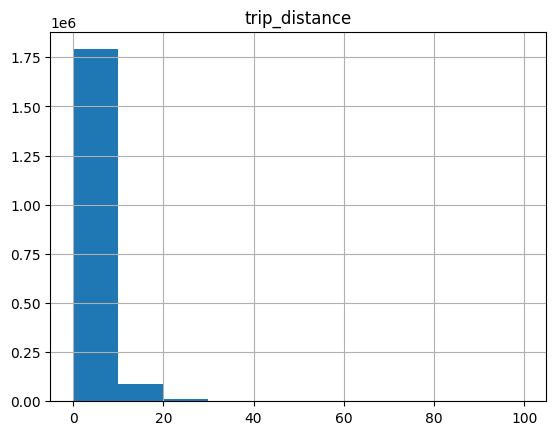

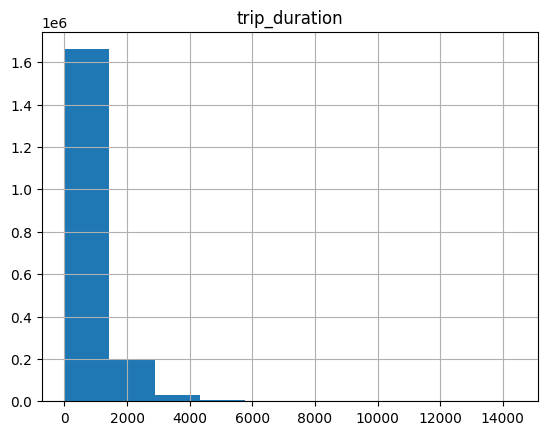

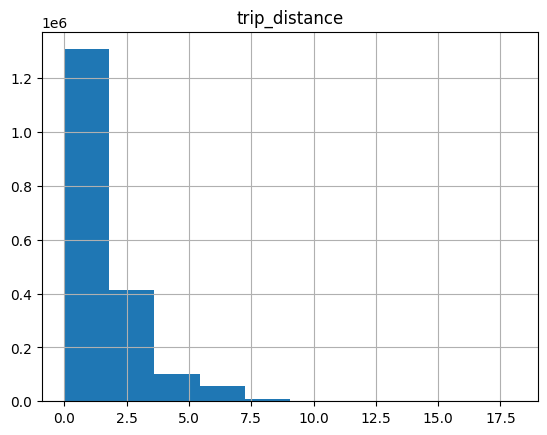

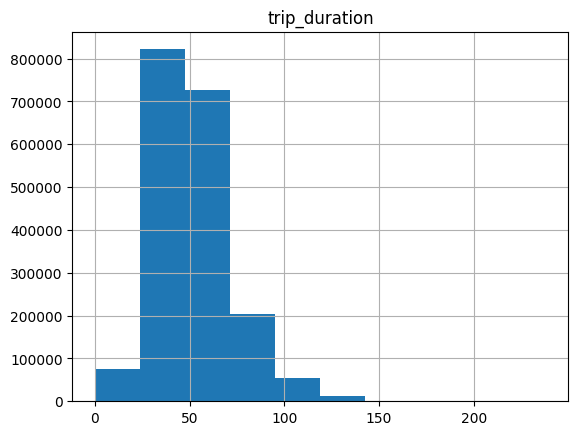

In [9]:
### SAMPLE IMPLEMENTATION ###

# visualize original data
sample_df = sample_data.to_pandas(limit=1893433)
sample_df.hist("trip_distance")
sample_df.hist("trip_duration")

# visualize transformed data
transformed_df = transformed_data.to_pandas(limit=1893433)
transformed_df.hist("trip_distance")
transformed_df.hist("trip_duration")

Notice the positively-skewed distributions for `trip_distance` and `trip_duration`. For these numerical features, you can choose an appropriate AIR `Preprocessor` depending on your data's properties:

- `PowerTransformer`: your data isn't normal, but you need it to be
- `Normalizer`: you need unit norm rows
- `MinMaxScaler`: you aren't sure what your data looks like

Feature scaling can offer a performance boost during training, and testing choice of `Preprocessor` is worth investigating when you have few features which are not already unit normalized.

### Summary

#### Key concepts

`Dataset`

The standard way to load and exchange data in Ray AIR. In AIR, Datasets are used extensively for data loading, preprocessing, and batch inference.

`Preprocessors`

Preprocessors are primitives that can be used to transform input data into features. Preprocessors operate on Datasets, which makes them scalable and compatible with a variety of datasources and dataframe libraries.

Preprocessors persist:

- during training to fit and transform input data
- in each trial of hyperparameter tuning
- within a checkpoint
- on input batches for inference

AIR comes with a collection of built-in preprocessors, and you can also define your own with simple templates which you can read more about in the [user guide](https://docs.ray.io/en/latest/ray-air/preprocessors.html).

## Part 4: Ray Train
***

Following data pre-processing, you can define the model for binary classification of big tip rides.

|<img src="images/train_highlight.png" width="70%" loading="lazy">|
|:--|
|Ray AIR wraps Ray Train to provide distributed model training.|

### Introduction to Ray Train

ML practitioners tend to run into a few common problems with training models that prompt them to consider distributed solutions:

1. training time is too long to be practical
2. the data is too large to fit on one machine
3. training many models sequentially doesn't utilize resources efficiently
4. the model itself is too large to fit on a single machine

[Ray Train](https://docs.ray.io/en/latest/ray-air/trainer.html) addresses these issues by cutting down runtime through distributed multi-node training with fault tolerance and leveraging Ray Data to distribute preprocessing and data ingestion.

Fully integrated into the Ray AIR ecosystem, `Trainer`s can plug into:

- Ray Data: to enable scalable data loading and preprocessing
- Ray Tune: for distributed hyperparameter tuning
- Ray AIR Predictor: as a checkpointed trained model to be applied during inference
- Popular ML training frameworks like:
    - PyTorch
    - Tensorflow
    - Horovod
    - XGBoost
    - HuggingFace Transformers
    - Scikit-Learn
    - and more

#### Key features

* callbacks for early stopping
* checkpointing
* integration with Tensorboard, Weights & Biases, and MLflow for observability
* export mechanisms for models

|<img src="images/train_code.png" width="70%" loading="lazy">|
|:--|
|Training comes in two major parts: defining the `Trainer` object and then fitting it to the training dataset. In this code snippet, you use a `TorchTrainer`, however, this may be swapped out with any [integrations](https://docs.ray.io/en/latest/ray-air/package-ref.html#trainer-and-predictor-integrations).|

Let's put these concepts in practice by applying it to our taxi problem.

### Define AIR `Trainer`

Ray AIR provides a variety of [`Trainer`s](https://docs.ray.io/en/latest/ray-air/trainer.html) (PyTorch, Tensorflow, HuggingFace, etc.). In the example below, you will use an `XGBoostTrainer` to perform binary classification on these NYC Taxi rides.

In [ ]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

In [ ]:
trainer = XGBoostTrainer(
    label_column="is_big_tip",
    num_boost_round=50,
    scaling_config=ScalingConfig(
        num_workers=5,
        use_gpu=False,
    ),
    params={
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "tree_method": "approx",
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor,
)

To construct a `Trainer`, you provide:

- a `ScalingConfig` which specifies how many parallel training workers and what type of resources (CPUs/GPUs) to use per worker during training
- a dictionary of training and validation sets
- the `Preprocessor` used to transform the `Dataset`s

Optionally, you can choose to add `resume_from_checkpoint` which allows you to continue training from a saved checkpoint should the run be interrupted.

### Fit the Trainer

In [ ]:
result = trainer.fit()

To invoke training, call `.fit()`. Trainer objects produce a `Result` object which gives you access to metrics, checkpoints, and errors.

**Coding exercise**

You can check out the training results from the `Result` object with the following calls:

```python
# returns last saved checkpoint
result.checkpoint

# returns the `n` best saved checkpoints as configured in `RunConfig.CheckpointConfig`
result.best_checkpoints

# returns the final metrics as reported
result.metrics

# returns the contain an Exception if training failed
result.error
```

Inspect your training result below. What is the reported accuracy for the training and validation runs? 

Note: `error` is the binary classification error rate in this case calculated as `#(wrong cases)/#(all cases)`

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [ ]:
### SAMPLE IMPLEMENTATION ###

print(f"Result metrics: \n {result.metrics} \n")

In [ ]:
### SAMPLE IMPLEMENTATION ###

print(f"Training accuracy: {1 - result.metrics['train-error']:.4f}")
print(f"Validation accuracy: {1 - result.metrics['valid-error']:.4f}")

### Summary

#### Key concepts

`Trainer`

Trainers are wrapper classes around third-party training frameworks such as XGBoost, Pytorch, and Tensorflow. They are built to help integrate with core Ray Actors (for distribution), Ray Datasets, and Ray Tune.

## Part 5: Ray Tune
***

Now that you have a baseline XGBoost model trained, you may want to improve performance by running hyperparameter tuning experiments.

|<img src="images/tune_highlight.png" width="70%" loading="lazy">|
|:--|
|Ray AIR wraps Ray Tune to provide distributed hyperparameter optimization.|

### Introduction to Ray Tune

<div class="alert alert-info">
  <strong><a href="https://en.wikipedia.org/wiki/Hyperparameter_optimization" target="_blank">Hyperparameter tuning (or optimization) (HPO)</a></strong> is the process of choosing optimal hyperparameters for a machine learning model. Hyperparameters, in contrast to weights learned by the model, are parameters that you set to influence training.
</div>


Setting up and executing hyperparameter optimization (HPO) can be expensive in terms of compute resources and runtime with several complexities including:

- **Vast Search Space**

    Your model could have several hyperparameters, each with different data types, ranges, and possible correlations.
    Sampling good candidates from high-dimensional spaces is difficult.
- **Search Algorithms**

    Choosing hyperparameters strategically requires testing complex search algorithms to achieve good results.
- **Long Runtime**

    Even if you distribute tuning, training complex models in themselves can take a long time to complete per run, so it's best to have an efficiency at every stage in the pipeline.
- **Resource Allocation**

    You must have enough compute resources available to during each trial as to not slow down search because of scheduling mismatches.
- **User Experience**

    Observability tooling for developers like stopping bad runs early, saving intermediate results, restarting from checkpoints, or pausing/resuming runs makes HPO easier.

Ray Tune is a distributed HPO library that addresses all of these topics above to provide a simplified interface for running trials and integrates with popular frameworks such as HyperOpt and Optuna.

|<img src="images/tune_code.png" width="70%" loading="lazy">|
|:--|
|General pattern for using AIR `Tuner`s which involves taking in a trainable, defining a search space, establishing a search algorithm, scheduling trials, and analyzing results.|

Let's see how to interact with Ray Tune to make some improvements to our big tip classifier.

### Use AIR `Tuner` for hyperparameter search

In [ ]:
from ray import tune
from ray.tune.tuner import Tuner, TuneConfig

In [ ]:
param_space = {
    "params": {
        "eta": tune.uniform(0.2, 0.4),
        "max_depth": tune.randint(1, 6),
        "min_child_weight": tune.uniform(0.8, 1.0),
    }
}

tuner = Tuner(
    trainer,
    param_space=param_space,
    tune_config=TuneConfig(num_samples=3, metric="train-logloss", mode="min"),
)

First define a search space with a few hyperparameters to tune:

- `eta` is the learning rate
- `max_depth` specifies how deep each tree is (default=6). A higher value leads to a more complex model.
- `min_child_weight` defines the minimum sum of weights of all observations in a child; used to control overfitting

To set up an AIR `Tuner`, you must specify:

- `Trainer`: the training loop
- `search space`: a set of hyperparameters you wish to tune
- `search_algorithm`: to optimize parameter search
- `scheduler`: (optional) to stop searches early and speed up experiments

### Execute hyperparameter search and analyze results

In [ ]:
result_grid = tuner.fit()

In [ ]:
best_result = result_grid.get_best_result()

Now, you can execute tuning on `num_samples=10` trials. After tuning, you can query the `ResultGrid` object to see metrics, results, and checkpoints of each trial.

**Coding exercise**

You can probe the `ResultGrid` for metrics using these calls:

```python

# checks if there have been errors
result_grid.errors

# gets the best result
best_result = result_grid.get_best_result()

# gets the best checkpoint
best_checkpoint = best_result.checkpoint

# gets the best metrics
best_metrics = best_result.metrics

```

Inspect your tunings results, what is the best result from these experiments? Are they better than the baseline model in the training step in the previous section?

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [ ]:
### SAMPLE IMPLEMENTATION ###

best_result = result_grid.get_best_result()
print(f"Best result: \n {best_result} \n")

In [ ]:
### SAMPLE IMPLEMENTATION ###

print(f"Training accuracy: {1 - best_result.metrics['train-error']:.4f}")
print(f"Validation accuracy: {1 - best_result.metrics['valid-error']:.4f}")

### Summary

#### Key concepts

`Tuner`

Provides an interface that works with AIR `Trainer`s to perform distributed hyperparameter tuning. You define a set of hyperparameters you wish to tune in a search space, specify a search algorithm, and the `Tuner` returns its results in a `ResultGrid` that contains metrics, results, and checkpoints for each `trial`.

## Part 6: Ray AIR Predictors
***

Ray AIR Predictors load models from [checkpoints](https://docs.ray.io/en/latest/ray-air/key-concepts.html#air-checkpoints-doc) generated during training or tuning to perform distributed inference.

`BatchPredictor` is a utility for large scale batch inference and takes in:
1. `Checkpoint` - a saved model from training or tuning
    - `Preprocessor` (optional) - defined earlier to transform input data for training can be reapplied to incoming batches
2. `Predictor` - loads model from checkpoint to perform inference

|<img src="images/batchpredict_code.png" width="70%" loading="lazy">|
|:--|
|`Checkpoint` and `Predictor` is passed into each instance of `BatchPredictor`|

### Use AIR `BatchPredictor` for Batch Prediction

Previously, you have trained and tuned our XGBoost model on data from June 2021. You will now take the best checkpoint from tuning and perform offline or batch inference on taxi tip data from June 2022.

In [ ]:
from ray.train.batch_predictor import BatchPredictor
from ray.train.xgboost import XGBoostPredictor

In [ ]:
test_dataset = ray.data.read_parquet(
    "s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2022.parquet"
).drop_columns("is_big_tip")

test_dataset = test_dataset.repartition(num_blocks=5)

### Create `BatchPredictor` from best trial of HPO

In [ ]:
batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=best_result.checkpoint, predictor_cls=XGBoostPredictor
)

Create a `BatchPredictor` by passing in the best result from the hyperparameter tuning step along with an XGBoost specific `Predictor` to handle the distributed inference step.

In [ ]:
predicted_probabilities = batch_predictor.predict(test_dataset)

Run batch inference on the testing dataset by calling `predict()`.

**Coding exercise**

Now that you have the predictions generated from the testing set, how did the model perform? Inspect the predictions outputted by `BatchPredictor` with the features and labels provided in `test_dataset`.

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [ ]:
### SAMPLE IMPLEMENTATION ###
predicted_probabilities.show(5)

### Summary

#### Key concepts

`Checkpoints`

Store the full state of the model periodically, so that partially trained models are available and can be used to resume training from an intermediate point, instead of starting from scratch; also allows for the best model to be saved for batch inference later on.

`BatchPredictor`

Loads the best model from a checkpoint to perform batch inference on large-scales or online inference.

## Part 7: Ray Serve
***

Finally, you may want to serve this taxi tip prediction application to end users, hopefully with a low latency to be maximally useful to drivers on the job. This poses a challenge since machine learning models are compute intensive and ideally, this model wouldn't be served in isolation, but rather adjacent to business logic or even other ML models.

|<img src="images/serve_highlight.png" width="70%" loading="lazy">|
|:--|
|Ray AIR wraps Ray Serve to provide distributed model serving.|

### Introduction to Ray Serve

Ray Serve is a scalable compute layer for serving machine learning models that enables serving individual models or creating composite model pipelines where you can independently deploy, update, and scale individual components. 

Serve isn't tied to a specific machine learning library, but rather treats models as ordinary Python code. 

Additionally, it allows you to flexibly combine normal Python business logic alongside machine learning models. This makes it possible to build online inference services completely end-to-end: 

- validate user input
- query a database
- perform inference scalably across multiple ML models
- combine, filter, and validate the output all in the process of handling a single inference request

|<img src="images/serve_code.png" width="70%" loading="lazy">|
|:--|
|Pattern for deploying a `Predictor` from a `Checkpoint` wth Ray Serve.|

### Use `PredictorDeployment` for Online Inference

### Deploy the XGBoost model from checkpoint

In [ ]:
from ray import serve
from ray.serve import PredictorDeployment
from ray.serve.http_adapters import pandas_read_json

In [ ]:
serve.run(
    PredictorDeployment.options(
        name="XGBoostService", num_replicas=2, route_prefix="/rayair"
    ).bind(XGBoostPredictor, best_result.checkpoint, http_adapter=pandas_read_json)
)

Deploy the best model as an inference service by using Ray Serve and the `PredictorDeployment` class. After deploying the service, you can send requests to it.

### Send some test traffic

In [ ]:
import requests

In [ ]:
sample_input = test_dataset.take(1)
sample_input = dict(sample_input[0])

output = requests.post("http://localhost:8000/rayair", json=[sample_input]).json()
print(output)

Try sending a request through HTTP. You can use the `PredictorDeployment` to deploy checkpoints trained in Ray AIR as live endpoints.

**Coding exercise**

You've just served a prediction for a single sample input from our test dataset. Predictors are able to accept array, dataframe, and custom inputs (that can be transformed to array or dataframe).

Try reading through the [user guide](https://docs.ray.io/en/latest/ray-air/examples/serving_guide.html), and try to set up your own input tp recieve a prediction from the model.

Note: There is much more to deployments that falls outside of the scope of this introductory module. For more, check out the resources listed in the final section of this notebook!

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [ ]:
### SAMPLE IMPLEMENTATION ###

# play with these inputs to receive predictions
passenger_count = 1
trip_distance = 10  # in miles
fare_amount = 45
trip_duration = 1200  # in seconds
hour = 18
day_of_week = 6

sample_input = {
    "passenger_count": passenger_count,
    "trip_distance": trip_distance,
    "fare_amount": fare_amount,
    "trip_duration": trip_duration,
    "hour": hour,
    "day_of_week": day_of_week,
}

output = requests.post("http://localhost:8000/rayair", json=[sample_input]).json()
print(output)

### Summary

#### Key concepts

`Deployments`

You can think of this as a managed group of Ray actors that can be addressed together and will handle requests load-balanced across them.

### Shutdown Ray runtime

In [ ]:
ray.shutdown()

Disconnect the worker, and terminate processes started by `ray.init()`.

## Part 8: Summary
***
You've now just created a Ray Dataset, preprocessed some features, built a model with XGBoost, searched a hyperparameter space for the best configuration, loaded the best model from a checkpoint to perform batch inference, and served that model for online inference. 

Through this end-to-end example, you explored how to use Ray AIR to distribute an entire ML pipeline.

### Key concepts

- `Datasets`

    The standard way to load and exchange data in Ray AIR. In AIR, Datasets are used extensively for data loading, preprocessing, and batch inference.

- `Preprocessors`

    Preprocessors are primitives that can be used to transform input data into features. Preprocessors operate on Datasets, which makes them scalable and compatible with a variety of datasources and dataframe libraries.

- `Trainers`

    Trainers are wrapper classes around third-party training frameworks such as XGBoost, Pytorch, and Tensorflow. They are built to help integrate with core Ray Actors (for distribution), Ray Datasets, and Ray Tune.

- `Tuner`

    Provides an interface that works with AIR Trainers to perform distributed hyperparameter tuning. You define a set of hyperparameters you wish to tune in a search space, specify a search algorithm, and the Tuner returns its results in a ResultGrid that contains metrics, results, and checkpoints for each trial.

- `Checkpoints`

    Store the full state of the model periodically, so that partially trained models are available and can be used to resume training from an intermediate point, instead of starting from scratch; also allows for the best model to be saved for batch inference later on.

- `BatchPredictor`

    Loads the best model from a checkpoint to perform batch inference on large-scales or online inference.

- `Deployments`

    You can think of this as a managed group of Ray actors that can be addressed together and will handle requests load-balanced across them.
    


# Connect with the Ray community

You can learn and get more involved with the Ray community of developers and researchers:

* [Ray documentation](https://docs.ray.io/en/latest)
* [Official Ray Website](https://www.ray.io/): Browse the ecosystem and use this site as a hub to get the information that you need to get going and building with Ray.
* [Join the Community on Slack](https://forms.gle/9TSdDYUgxYs8SA9e8): Find friends to discuss your new learnings in our Slack space.
* [Use the Discussion Board](https://discuss.ray.io/): Ask questions, follow topics, and view announcements on this community forum.
* [Join a Meetup Group](https://www.meetup.com/Bay-Area-Ray-Meetup/): Tune in on meet-ups to listen to compelling talks, get to know other users, and meet the team behind Ray.
* [Open an Issue](https://github.com/ray-project/ray/issues/new/choose): Ray is constantly evolving to improve developer experience. Submit feature requests, bug-reports, and get help via GitHub issues.
* [Become a Ray contributor](https://docs.ray.io/en/latest/ray-contribute/getting-involved.html): We welcome community contributions to improve our documentation and Ray framework.

<img src="images/ray_logo.png" width="20%" loading="lazy">